In [1]:
import numpy as np
from pointpattern import PointPattern
%matplotlib inline
import matplotlib.pyplot as plt
points = [[66.22, 32.54], [22.52, 22.39], [31.01, 81.21], [9.47, 31.02],
               [30.78, 60.10], [75.21, 58.93], [79.26,  7.68], [8.23, 39.93],
               [98.73, 80.53], [89.78, 42.53], [65.19, 92.08], [54.46, 8.48]]

In [2]:
from centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance

In [3]:
pp = PointPattern(points)
hull(pp.points)

array([[ 31.01,  81.21],
       [  8.23,  39.93],
       [  9.47,  31.02],
       [ 22.52,  22.39],
       [ 54.46,   8.48],
       [ 79.26,   7.68],
       [ 89.78,  42.53],
       [ 98.73,  80.53],
       [ 65.19,  92.08]])

In [4]:
std_distance(pp.points)

40.376087326260055

In [5]:
mean_center(pp.points)

array([ 52.57166667,  46.45166667])

In [6]:
manhattan_median(pp.points)

centrography.py:80: UserWarning: Manhattan Median is not unique for even point patterns.
  warnings.warn(s)


array([ 59.825,  41.23 ])

In [7]:
np.median(points, axis=0)

array([ 59.825,  41.23 ])

In [8]:
points = np.array(points)

In [9]:
points

array([[ 66.22,  32.54],
       [ 22.52,  22.39],
       [ 31.01,  81.21],
       [  9.47,  31.02],
       [ 30.78,  60.1 ],
       [ 75.21,  58.93],
       [ 79.26,   7.68],
       [  8.23,  39.93],
       [ 98.73,  80.53],
       [ 89.78,  42.53],
       [ 65.19,  92.08],
       [ 54.46,   8.48]])

In [10]:
weights = np.arange(12)
wmc = weighted_mean_center(pp.points, weights)
wmc
med = manhattan_median(pp.points)
mc = mean_center(pp.points)

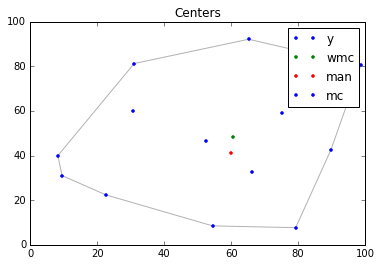

In [11]:
pp.plot(title='Centers', hull=True )
plt.plot(wmc[0], wmc[1], 'g.', label='wmc')
plt.plot(med[0], med[1], 'r.', label='man')
plt.plot(mc[0], mc[1], 'b.', label='mc')
plt.legend(loc=0)



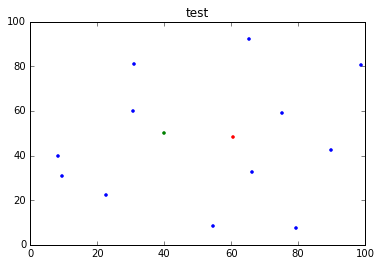

In [12]:
ax = pp.plot(title='test', get_ax=True)
ax.plot(wmc[0], wmc[1], 'r.')
ax.plot(40,50, 'g.')


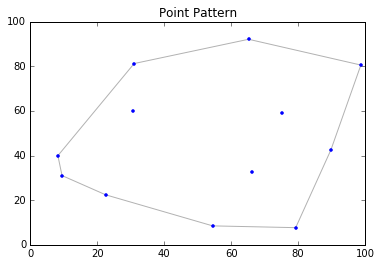

In [13]:
pp.plot(hull=True)

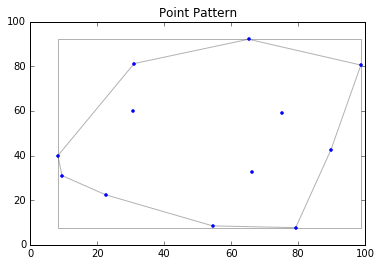

In [14]:
pp.plot(hull=True, window=True)

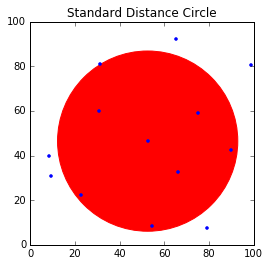

In [15]:
stdd = std_distance(pp.points)
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r')
ax = pp.plot(get_ax=True, title='Standard Distance Circle')
ax.add_artist(circle1)
plt.plot(mc[0], mc[1], 'b.', label='mc')
ax.set_aspect('equal')


#plt.xlim(-100,100)
#plt.ylim(-100,100)

#plt.show()


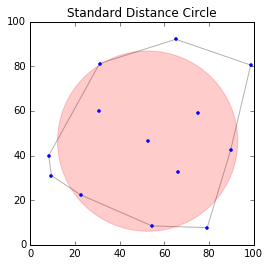

In [16]:
stdd = std_distance(pp.points)
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r',alpha=0.2)
ax = pp.plot(get_ax=True, title='Standard Distance Circle', hull=True)
ax.add_artist(circle1)
plt.plot(mc[0], mc[1], 'b.', label='mc')
ax.set_aspect('equal')


#plt.xlim(-100,100)
#plt.ylim(-100,100)

#plt.show()


In [17]:
pp.hull

array([[ 31.01,  81.21],
       [  8.23,  39.93],
       [  9.47,  31.02],
       [ 22.52,  22.39],
       [ 54.46,   8.48],
       [ 79.26,   7.68],
       [ 89.78,  42.53],
       [ 98.73,  80.53],
       [ 65.19,  92.08]])

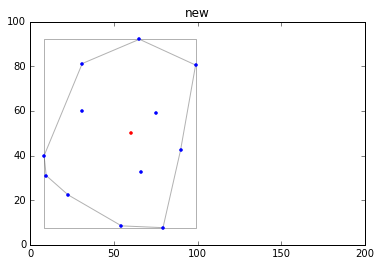

In [18]:
ax = pp.plot(hull=True, window=True, get_ax=True)
ax.set_xlim(0,200)
ax.plot(60,50,'r.')
plt.title('new')

In [19]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 u'_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_axisbg',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_cursorProps',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_legend_handles',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_init_axis',
 '_label',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_navigate',
 '_navigate_mode',
 '_oid',
 '_originalPosition',
 '_path_effects',
 '_pcolorargs',
 '_picker',
 '_position',
 '_

In [20]:
pp

In [21]:
pp.summary()

Point Pattern
12 points
Bounding rectangle [(8.23,7.68), (98.73,92.08)]
Area of window: 7638.2
Intensity estimate for window: 0.00157105077112


In [22]:

pp.points

,x,y
0,66.22,32.54
1,22.52,22.39
2,31.01,81.21
3,9.47,31.02
4,30.78,60.10
5,75.21,58.93
6,79.26,7.68
7,8.23,39.93
8,98.73,80.53
9,89.78,42.53
